# 데이터 불러오기

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [3]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier()),
    ])
params = {
    'clf__weights': ['uniform','distance'],
    'clf__p': [1,2],
    'clf__n_neighbors': list(range(1,21)),
    }
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__weights': 'uniform'}
0.7683743403152125


In [6]:
pred = grid.predict(X_test)

In [7]:
#confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, pred)
cm

array([[1134,  241],
       [ 323, 1051]], dtype=int64)

In [8]:
df_cm=pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
df_cm

,0,1
0,1134,241
1,323,1051


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1375
           1       0.81      0.76      0.79      1374

    accuracy                           0.79      2749
   macro avg       0.80      0.79      0.79      2749
weighted avg       0.80      0.79      0.79      2749



# 시각화

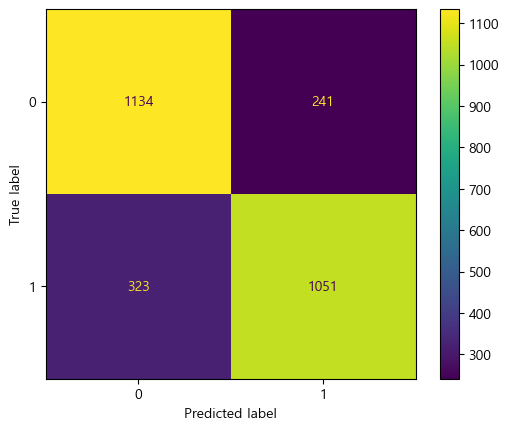

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_).plot()

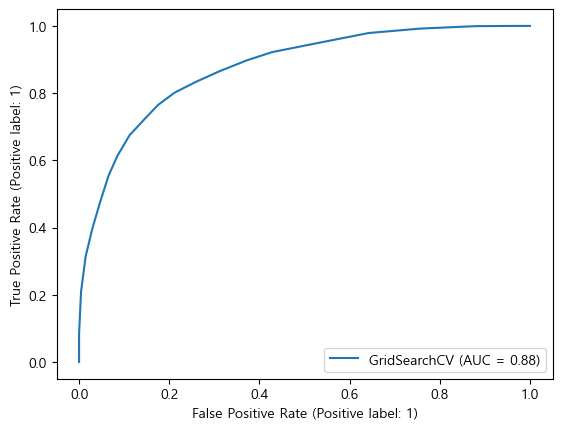

In [20]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(grid, X_test, y_test)

# 저장

In [30]:
result = pd.read_csv('../csv/model_results.csv')
result

,Model,Best Score,Best Parameter
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we..."
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,..."
2,DNN,0.784456,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c..."
3,Tree,0.692843,{'clf__max_depth': 4}
4,Logit,0.787949,"{'clf__C': 0.1, 'clf__class_weight': 'balanced..."
5,RF,0.752439,"{'clf__max_depth': 4, 'clf__n_estimators': 40}"
6,SVM,0.788677,"{'clf__C': 1000, 'clf__gamma': 0.0001}"


In [31]:
if 'KNN' in result.Model.values.tolist():
    result.loc[result.Model.values.tolist().index('KNN')] = ['KNN', grid.best_score_, grid.best_params_]
else:
    result.loc[len(result.index)] = ['KNN', grid.best_score_, grid.best_params_]
result

,Model,Best Score,Best Parameter
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we..."
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,..."
2,DNN,0.784456,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c..."
3,Tree,0.692843,{'clf__max_depth': 4}
4,Logit,0.787949,"{'clf__C': 0.1, 'clf__class_weight': 'balanced..."
5,RF,0.752439,"{'clf__max_depth': 4, 'clf__n_estimators': 40}"
6,SVM,0.788677,"{'clf__C': 1000, 'clf__gamma': 0.0001}"


In [32]:
result.to_csv('../csv/model_results.csv', index=None)

In [24]:
model = grid.best_estimator_['clf']

In [33]:
import joblib
joblib.dump(model, 'c:/bank_account_fraud/model/knn.model')
joblib.dump(model, 'c:/bank_account_fraud/model/knn.weight')

['c:/bank_account_fraud/model/knn.weight']